In [3]:
import numpy as np 
from numpy import percentile
import pandas as pd
import os
import scipy
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# !pip install git+https://github.com/shakedzy/dython.git

In [5]:
tt = pd.read_csv('/kaggle/input/housing-train-and-test/tt.csv')

In [6]:
tt = tt.drop('State', axis=1).copy()
tt = tt.astype({'Zip': 'object'}).copy()

In [7]:
train = tt.loc[:47438].copy()

# Baseline model peformance

create train baseline, one hot encode then drop all NaNs ... this will gives us something to compare to 

In [131]:
train = train.drop('Id', axis=1).copy()

In [164]:
train_quantitative = train[quantitative]

In [167]:
train_quantitative = train_quantitative.dropna().copy()

In [170]:
train_quantitative.shape

(23738, 19)

In [168]:
# evaluate model on the raw dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# split into input and output elements
X, y = train_quantitative.drop('Sold_Price', axis=1), train_quantitative.Sold_Price
print(X.shape, y.shape)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# # fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(23738, 18) (23738,)
MAE: 221057.049


# Demark quantitative and qualitative

In [9]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('Sold_Price')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [10]:
quantitative, qualitative

(['Year_built',
  'Lot',
  'Bedrooms',
  'Bathrooms',
  'Full_bathrooms',
  'Total_interior_livable_area',
  'Total_spaces',
  'Garage_spaces',
  'Tax_assessed_value',
  'Annual_tax_amount',
  'Listed_Price',
  'Last_Sold_Price',
  'Days_Listed',
  'Days_Sold',
  'Address_NoLen',
  'Summary_Len',
  'Schools_Score',
  'Schools_Distance',
  'Total_Appliances'],
 ['Type',
  'Heating',
  'Cooling',
  'Parking',
  'Flooring',
  'Zip',
  'Address_RdType',
  'Hookups'])

# Testing for normality

In [11]:
def normality_tests(df, quantitative):
    Feature = []
    Shapiro_Wilk = []
    K2_Test = []
    Anderson_Darling = []
    for x in quantitative:
        Feature.append(x)
        Shapiro_Wilk.append(shapiro(df[x].dropna())[1])
        K2_Test.append(normaltest(df[x].dropna())[1])
        result = anderson(df[x].dropna())
        Anderson_Darling.append('Reject H0' if result.statistic < result.critical_values[2] else 'Failed to reject H0')
    print(f"H0: Distribution is Gaussian. If p > 0.05 means it is very likely, not certain, the distribution is Gaussian.\nShapiro-Wilk p-value may not be accurate when N > 5000. The DataFrame has {train.shape[0]} values.\nAnderson-Darling at 0.05 signifigance level.")
    out = pd.DataFrame(data=[Shapiro_Wilk, K2_Test, Anderson_Darling], index=['Shapiro-Wilk','K^2 Test','Anderson-Darling'], columns=Feature)
    out = out.transpose().copy()
    out = out.style.applymap(lambda x: "background-color: red" if type(x) != str and x<0.05 or type(x) == str and x =='Reject H0' else "background-color: green")
    return out

In [12]:
normality_tests(train, quantitative)

/opt/conda/lib/python3.10/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


H0: Distribution is Gaussian. If p > 0.05 means it is very likely, not certain, the distribution is Gaussian.
Shapiro-Wilk p-value may not be accurate when N > 5000. The DataFrame has 47439 values.
Anderson-Darling at 0.05 signifigance level.


,Shapiro-Wilk,K^2 Test,Anderson-Darling
Year_built,0.000000,0.000000,Failed to reject H0
Lot,0.000000,0.000000,Failed to reject H0
Bedrooms,0.000000,0.000000,Failed to reject H0
Bathrooms,0.000000,0.000000,Failed to reject H0
Full_bathrooms,0.000000,0.000000,Failed to reject H0
Total_interior_livable_area,0.000000,0.000000,Failed to reject H0
Total_spaces,0.000000,0.000000,Failed to reject H0
Garage_spaces,0.000000,0.000000,Failed to reject H0
Tax_assessed_value,0.000000,0.000000,Failed to reject H0
Annual_tax_amount,0.000000,0.000000,Failed to reject H0


In [13]:
def normality_graphic(x):
    h= plt.hist(x, bins='auto')
    qq=qqplot(x, line='45')
    return h[2], qq

#need to expand hist to show full range of values ... take total number of unique values and divide by x? some function of unique and range?

# Detecting and removing outliers

We can't assume a Gaussian distribution as Hard Fail for all quantiative features. 

## Assumptions

* Non-parametric, the distribution is not Gaussian

## IQR

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/

In [14]:
def iqr(x, k, w, h):
    #k is for k factor, above what factor of IQR do we define value as being an outlier
    q25, q75 = percentile(x, 25), percentile(x, 75)
    iqr = q75 - q25
    cut_off = iqr*k
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [v for v in x if v < lower or v > upper]
    non_outliers = [v for v in x if v >= lower and v <= upper]
    print(f"""
    Percentiles: 25th={round(q25,2)}, 75th={round(q75, 2)}, IQR={round(iqr, 2)}
    Identified outliers: {len(outliers)}
    Non-outliers: {len(non_outliers)}
    """)
    fig = plt.figure(figsize=(w,h))
    plt.boxplot(x)
    return plt.show()


    Percentiles: 25th=565000.0, 75th=1525000.0, IQR=960000.0
    Identified outliers: 2814
    Non-outliers: 44625
    


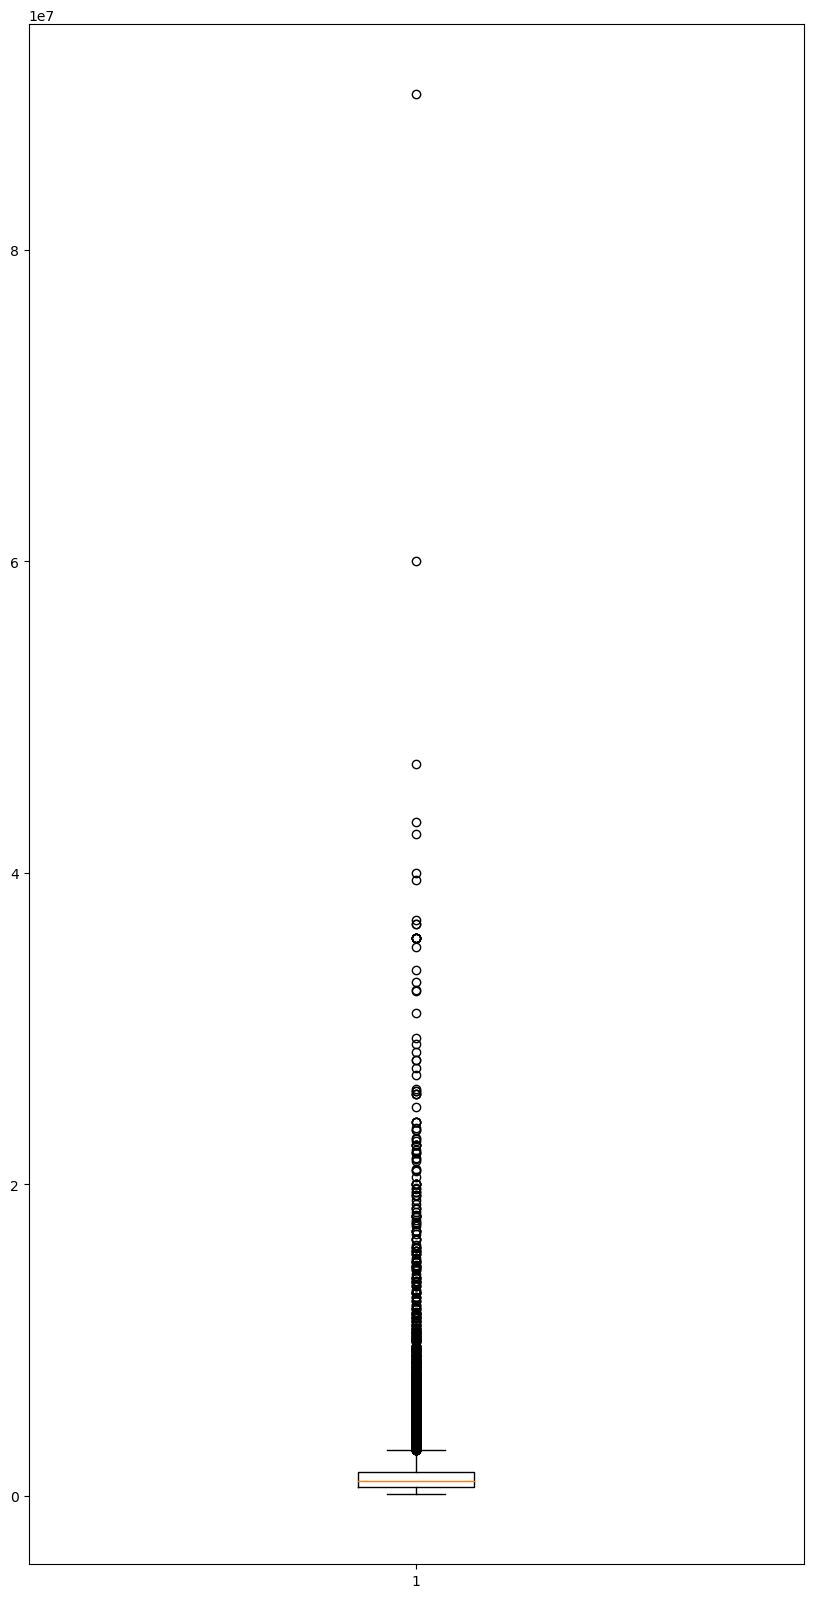

In [15]:
iqr(train.Sold_Price, 1.5, 10,20)

# Identify and modify outliers

for each column of quantitative data

identify outliers 

replace outliers with 'NaN'

return datframe with outliers replaced by NaN

In [72]:
np.nanpercentile(train.Year_built, 75)

1989.0

In [113]:
def remove_outliers(df, quantitative, k):
    df = df.copy()
    quantitative.append('Sold_Price')
    for x in quantitative:
        q25, q75 = np.nanpercentile(df[x], 25), np.nanpercentile(df[x], 75)
        iqr = q75 - q25
        cut_off = iqr*k
        lower, upper = q25 - cut_off, q75 + cut_off
        df[x] = np.where(df[x] < lower, np.nan, df[x]).copy()
        df[x] = np.where(df[x] > upper, np.nan, df[x]).copy()
    return df

In [114]:
train_iqr = remove_outliers(train, quantitative, 1.5)

In [115]:
normality_tests(train_iqr, quantitative)

/opt/conda/lib/python3.10/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.10/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/opt/conda/lib/python3.10/site-packages/scipy/stats/morestats.py:1863: RuntimeWarning: invalid value encountered in divide
  w = (y - xbar) / s


H0: Distribution is Gaussian. If p > 0.05 means it is very likely, not certain, the distribution is Gaussian.
Shapiro-Wilk p-value may not be accurate when N > 5000. The DataFrame has 47439 values.
Anderson-Darling at 0.05 signifigance level.


,Shapiro-Wilk,K^2 Test,Anderson-Darling
Year_built,0.000000,0.000000,Failed to reject H0
Bedrooms,0.000000,0.000000,Failed to reject H0
Bathrooms,0.000000,0.000000,Failed to reject H0
Full_bathrooms,1.000000,0.000000,Failed to reject H0
Total_interior_livable_area,0.000000,0.000000,Failed to reject H0
Total_spaces,0.000000,0.000000,Failed to reject H0
Garage_spaces,0.000000,0.000000,Failed to reject H0
Tax_assessed_value,0.000000,0.000000,Failed to reject H0
Annual_tax_amount,0.000000,0.000000,Failed to reject H0
Listed_Price,0.000000,0.000000,Failed to reject H0


Using IQR resulted in a Hard Fail for all, other options are to use automatic outlier detection or transform the data to a normal distribution ... will need to compare non-parametric and parametric models

## Automatic outlier detection

## Assessing the methods

will need to create and run the model for this?